In [47]:
%load_ext autoreload
%autoreload 2

import os

subj = "Subj1"
N_STAGES = 9

exp = "exp_full_flow"
os.makedirs(f"{subj}/{exp}", exist_ok = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import typing

import mne
import umap
import tqdm
import numpy
import pandas
import joblib
import itertools
import sklearn.metrics
import sklearn.preprocessing
import sklearn.decomposition
import tqdm.contrib.itertools
import matplotlib.pyplot as plt
import sklearn.cross_decomposition

import SDA.topology
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

from full_flow.AutoEncoder import AutoEncoder

In [49]:
QSDA_THRESHOLD = 0.4
UNIQUE_VALUES_THRESHOLD = 200
TRY_NUM_FEATURES = list(range(25, 1000, 50))

### Data

Opening raw data file Subj1/src/data_rr_filt-raw.fif...
    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


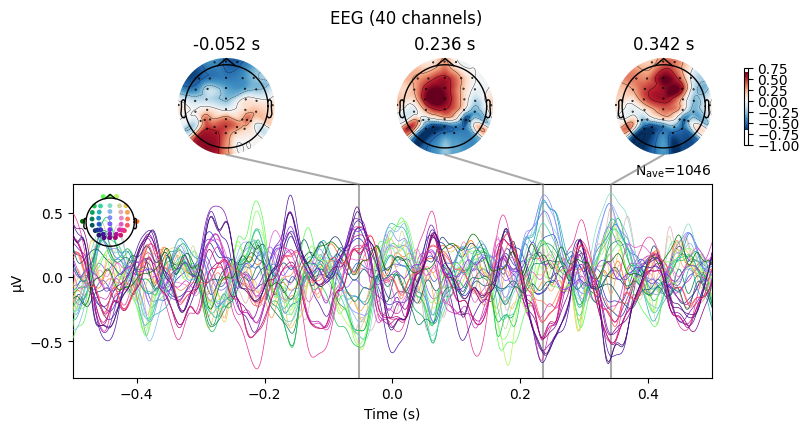

In [50]:
edges_true = numpy.loadtxt(f"{subj}/{exp}/target_edges.txt").astype(numpy.int32)

raw_data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]

epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")
data = epochs.get_data(copy = True)

### Features

In [51]:
per_channel_folder = f"{subj}/{exp}/features/per_channel"
os.makedirs(per_channel_folder, exist_ok = True)
per_channel_extractor = SDA.topology.PerChannelFeatureExtractor(n_jobs = -1, folder = per_channel_folder)
per_channel_features = per_channel_extractor.extract(data)

dissimilarity_folder = f"{subj}/{exp}/features/dissimilarity"
os.makedirs(dissimilarity_folder, exist_ok = True)
dissimilarity_extractor = SDA.topology.DissimilarityFeatureExtractor(n_jobs = -1, folder = dissimilarity_folder)
dissimilarity_features = dissimilarity_extractor.extract(data)

overall_folder = f"{subj}/{exp}/features/overall"
os.makedirs(overall_folder, exist_ok = True)
overall_extractor = SDA.topology.OverallFeatureExtractor(n_jobs = -1, folder = overall_folder)
overall_features = overall_extractor.extract(data)

all_features = pandas.concat([
    per_channel_features,
    dissimilarity_features,
    overall_features
], axis = 1)

all_features.to_feather(f"{subj}/{exp}/features/all_features.feather")
display(all_features)

Got features from Subj1/exp_full_flow/features/per_channel/features.feather
Got features from Subj1/exp_full_flow/features/dissimilarity/features.feather
Got features from Subj1/exp_full_flow/features/overall/features.feather


,channel-0 betti dim-1 max,channel-0 betti dim-1 mean,channel-0 betti dim-1 std,channel-0 betti dim-1 sum,channel-0 betti dim-1 percentile-25,channel-0 betti dim-1 median,channel-0 betti dim-1 percentile-75,channel-0 betti dim-1 kurtosis,channel-0 betti dim-1 skew,channel-0 betti dim-1 norm-1,...,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 percentile-25,overall bd2 dim-3 median,overall bd2 dim-3 percentile-75,overall bd2 dim-3 kurtosis,overall bd2 dim-3 skew,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,20.0,0.0,3.081388,0.0,0.0,0.0,0.0,22.648126,1.984461,74.0,...,0.000079,6.284464e-07,0.000237,0.000079,0.000079,0.000079,-1.500000,0.694641,0.000237,0.000137
1,25.0,0.0,3.634848,0.0,0.0,0.0,0.0,36.287665,0.716812,74.0,...,0.000086,6.442289e-06,0.000259,0.000083,0.000089,0.000091,-1.500000,-0.495956,0.000259,0.000150
2,14.0,0.0,2.522625,0.0,0.0,0.0,0.0,21.617551,1.419534,62.0,...,0.000086,2.472704e-06,0.000258,0.000084,0.000085,0.000087,-1.500000,0.356254,0.000258,0.000149
3,10.0,0.0,1.874874,0.0,0.0,0.0,0.0,24.055291,-0.873622,50.0,...,0.000118,1.172669e-05,0.000354,0.000114,0.000126,0.000126,-1.500000,-0.705968,0.000354,0.000205
4,6.0,0.0,1.614330,0.0,0.0,0.0,0.0,19.211195,-2.146474,44.0,...,0.000071,0.000000e+00,0.000071,0.000071,0.000071,0.000071,0.000000,0.000000,0.000071,0.000071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,13.0,0.0,1.693720,0.0,0.0,0.0,0.0,34.348393,3.916706,48.0,...,0.000157,3.084008e-05,0.001569,0.000142,0.000143,0.000191,-1.511026,0.037182,0.001569,0.000506
1042,6.0,0.0,0.953463,0.0,0.0,0.0,0.0,18.193333,1.887856,30.0,...,0.000178,3.527353e-05,0.001069,0.000154,0.000155,0.000207,-1.453271,0.710438,0.001069,0.000445
1043,12.0,0.0,1.847740,0.0,0.0,0.0,0.0,24.860106,2.853318,46.0,...,0.000126,0.000000e+00,0.000126,0.000126,0.000126,0.000126,0.000000,0.000000,0.000126,0.000126
1044,5.0,0.0,0.864566,0.0,0.0,0.0,0.0,13.957999,1.500518,28.0,...,0.000117,5.181228e-07,0.000234,0.000117,0.000117,0.000117,-2.000000,0.000000,0.000234,0.000165


In [52]:
features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
features = pandas.DataFrame(features, columns = all_features.columns)

features.to_feather(f"{subj}/{exp}/features/features.feather")
display(features)

numpy.save(f"{subj}/{exp}/features/features.npy", features.to_numpy())

,channel-0 betti dim-1 max,channel-0 betti dim-1 mean,channel-0 betti dim-1 std,channel-0 betti dim-1 sum,channel-0 betti dim-1 percentile-25,channel-0 betti dim-1 median,channel-0 betti dim-1 percentile-75,channel-0 betti dim-1 kurtosis,channel-0 betti dim-1 skew,channel-0 betti dim-1 norm-1,...,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 percentile-25,overall bd2 dim-3 median,overall bd2 dim-3 percentile-75,overall bd2 dim-3 kurtosis,overall bd2 dim-3 skew,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,1.740911,0.0,2.110733,0.0,0.0,0.0,0.0,-0.523849,0.244968,2.852528,...,-0.291732,-0.637585,-0.398783,-0.242549,-0.305271,-0.342706,-0.707397,1.361278,-0.398783,-0.358632
1,2.719414,0.0,2.979147,0.0,0.0,0.0,0.0,0.748634,-0.371046,2.852528,...,-0.151636,0.018949,-0.352795,-0.151771,-0.115099,-0.136724,-0.707397,-0.701141,-0.352795,-0.269469
2,0.566708,0.0,1.234001,0.0,0.0,0.0,0.0,-0.619995,-0.029558,1.828477,...,-0.157325,-0.429321,-0.354662,-0.126262,-0.176243,-0.196790,-0.707397,0.775105,-0.354662,-0.275374
3,-0.216094,0.0,0.217640,0.0,0.0,0.0,0.0,-0.392569,-1.143917,0.804425,...,0.448923,0.615695,-0.155652,0.453311,0.586774,0.497639,-0.707397,-1.064935,-0.155652,0.104824
4,-0.998896,0.0,-0.191170,0.0,0.0,0.0,0.0,-0.844493,-1.762459,0.292400,...,-0.444769,-0.708553,-0.744440,-0.393258,-0.449392,-0.491009,0.810932,0.157982,-0.744440,-0.804797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,0.371008,0.0,-0.066602,0.0,0.0,0.0,0.0,0.567712,1.183942,0.633750,...,1.190094,2.774092,2.373848,1.018122,0.916795,1.652314,-0.718557,0.222390,2.373848,2.138891
1042,-0.998896,0.0,-1.228111,0.0,0.0,0.0,0.0,-0.939453,0.198023,-0.902327,...,1.593141,3.274745,1.332063,1.255880,1.136752,1.933515,-0.660097,1.388642,1.332063,1.726088
1043,0.175307,0.0,0.175064,0.0,0.0,0.0,0.0,-0.317485,0.667189,0.463075,...,0.608793,-0.708553,-0.629157,0.704803,0.594051,0.499688,0.810932,0.157982,-0.629157,-0.429753
1044,-1.194596,0.0,-1.367594,0.0,0.0,0.0,0.0,-1.334583,0.009796,-1.073002,...,0.429385,-0.650044,-0.405427,0.512682,0.416366,0.335619,-1.213507,0.157982,-0.405427,-0.165668


### Feature selection

In [53]:
os.makedirs(f"{subj}/{exp}/qsda", exist_ok = True)
qsda = SDA.QSDA(
    n_jobs = 1,
    qsda_n_jobs = 14,
    scores_folder = f"{subj}/{exp}/qsda",

    threshold = QSDA_THRESHOLD,
    min_unique_values = UNIQUE_VALUES_THRESHOLD
)
best_features, scores = qsda.select(features)

best_features.to_feather(f"{subj}/{exp}/qsda/best_features.feather")
numpy.save(f"{subj}/{exp}/qsda/best_features.npy", features.to_numpy())
display(best_features)
display(scores)

,channel-0 landscape dim-1 max,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 std,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 norm-1,channel-0 landscape dim-1 norm-2,channel-0 silhouette-1 dim-1 max,channel-0 silhouette-1 dim-1 mean,channel-0 silhouette-1 dim-1 std,channel-0 silhouette-1 dim-1 sum,...,overall bd2 all sum,overall bd2 all norm-1,overall bd2 all norm-2,overall bd2 dim-1 sum,overall bd2 dim-1 kurtosis,overall bd2 dim-1 norm-1,overall bd2 dim-1 norm-2,overall bd2 dim-3 sum,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,-0.806634,-0.520502,-0.659249,-0.520502,-0.520502,-0.633313,-0.569798,-0.380670,-0.488455,-0.380670,...,0.960431,0.960431,0.445336,1.135221,-0.230173,1.135221,0.704229,-0.398783,-0.398783,-0.358632
1,-1.020976,-0.551943,-0.774106,-0.551943,-0.551943,-0.735120,-0.673813,-0.403483,-0.538255,-0.403483,...,0.686711,0.686711,0.390763,1.043360,0.007804,1.043360,0.789946,-0.352795,-0.352795,-0.269469
2,-0.598215,-0.407366,-0.483179,-0.407366,-0.407366,-0.469525,-0.423210,-0.339031,-0.411784,-0.339031,...,0.767908,0.767908,0.332392,0.679854,0.568918,0.679854,0.395351,-0.354662,-0.354662,-0.275374
3,-0.783899,-0.345601,-0.530000,-0.345601,-0.345601,-0.500104,-0.648575,-0.366175,-0.517864,-0.366175,...,0.290333,0.290333,0.364773,0.536110,-0.222034,0.536110,0.662948,-0.155652,-0.155652,0.104824
4,-0.775933,-0.464006,-0.617751,-0.464006,-0.464006,-0.591066,-0.448725,-0.349089,-0.416720,-0.349089,...,1.066939,1.066939,0.460320,1.504026,-0.515080,1.504026,0.885237,-0.744440,-0.744440,-0.804797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,1.253032,0.815099,1.047552,0.815099,0.815099,0.997798,0.644301,0.340212,0.469666,0.340212,...,1.248625,1.248625,1.618025,0.855649,-0.206653,0.855649,1.248304,2.373848,2.373848,2.138891
1042,3.186450,3.271276,3.416822,3.271276,3.271276,3.386493,2.203729,2.671206,2.725941,2.671206,...,0.925224,0.925224,2.056730,0.148281,-0.057424,0.148281,1.446911,1.332063,1.332063,1.726088
1043,0.667143,0.208674,0.455257,0.208674,0.208674,0.407828,0.480932,0.133287,0.362325,0.133287,...,-1.059349,-1.059349,-0.542870,-1.137874,-0.712716,-1.137874,-0.557530,-0.629157,-0.629157,-0.429753
1044,0.735706,0.733759,0.893808,0.733759,0.733759,0.857392,0.779406,0.478075,0.671707,0.478075,...,-1.334617,-1.334617,-0.956489,-1.385140,-0.142248,-1.385140,-1.011251,-0.405427,-0.405427,-0.165668


,name,score,mean,variance,unique_values,normalized_score
0,channel-0 betti dim-1 max,0.602317,1.358590e-17,1.0,31,0.156897
1,channel-0 betti dim-1 mean,0.000000,0.000000e+00,0.0,1,0.031732
2,channel-0 betti dim-1 std,0.605209,-4.347489e-16,1.0,376,0.157498
3,channel-0 betti dim-1 sum,0.000000,0.000000e+00,0.0,1,0.031732
4,channel-0 betti dim-1 percentile-25,0.000000,0.000000e+00,0.0,1,0.031732
...,...,...,...,...,...,...
19558,overall bd2 dim-3 percentile-75,1.207155,9.510132e-17,1.0,861,0.282587
19559,overall bd2 dim-3 kurtosis,0.238506,-1.154802e-16,1.0,466,0.081295
19560,overall bd2 dim-3 skew,0.422302,5.943833e-18,1.0,538,0.119489
19561,overall bd2 dim-3 norm-1,2.375467,2.717181e-17,1.0,861,0.525370


### Dimensionality reduction

In [54]:
print(TRY_NUM_FEATURES)
for n_components in TRY_NUM_FEATURES:
    file = f"{subj}/{exp}/features_reduced/rtd_ae/{n_components}/features.npy"
    if not os.path.exists(file):
        raise NotImplementedError(f'Need to run RTD_AE for {n_components} components manually')

class RTDAutoEncoder:
    def __init__(self, n_components: int):
        self.n_components = n_components

    def fit_transform(self, features: numpy.ndarray):
        return numpy.load(f"{subj}/{exp}/features_reduced/rtd_ae/{self.n_components}/features.npy")

[25, 75, 125, 175, 225, 275, 325, 375, 425, 475, 525, 575, 625, 675, 725, 775, 825, 875, 925, 975]


In [55]:
def make_reduced(
    methods: typing.List[typing.Tuple[str, typing.Callable[[numpy.ndarray], numpy.ndarray]]],
    full_features: pandas.DataFrame
):
    def reduce(name: str, method, n_components: int, full_features: numpy.ndarray):
        folder = f"{subj}/{exp}/features_reduced/{name}/{n_components}"
        os.makedirs(folder, exist_ok = True)
        
        features_file = f"{folder}/features.npy"
        if os.path.exists(features_file):
            reduced_features = numpy.load(features_file)
        else:
            reduced_features = method.fit_transform(full_features)
            numpy.save(features_file, reduced_features)
        
        results_file = f"{folder}/results.csv"
        if not os.path.exists(results_file):
            sda = SDA.SDA(n_jobs = 1, scale = False, verbose = False, st1_calc_quality = False)
            results, _ = sda.apply(reduced_features)
            results.to_csv(results_file, index = False)

    generator = joblib.Parallel(return_as = "generator", n_jobs = -1)(
        joblib.delayed(reduce)(name, method(n_components = n_components, **params), n_components, full_features.to_numpy())
        for n_components, (name, method, params) in itertools.product(TRY_NUM_FEATURES, methods)
    )
    list(tqdm.tqdm(generator, total = len(methods) * len(TRY_NUM_FEATURES)))

methods = [
    ('pca', sklearn.decomposition.PCA, { 'svd_solver': "full", 'random_state': 42 }),
    ('umap', umap.UMAP, { 'random_state': 42 }),
    ('ae', AutoEncoder, { 'n_features': best_features.shape[1] }),
    ('rtd_ae', RTDAutoEncoder, { })
]
make_reduced(methods, best_features)

 24%|██▍       | 19/80 [19:30<53:31, 52.65s/it]  d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 80/80 [1:56:11<00:00, 87.14s/it]   


rtd_ae: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


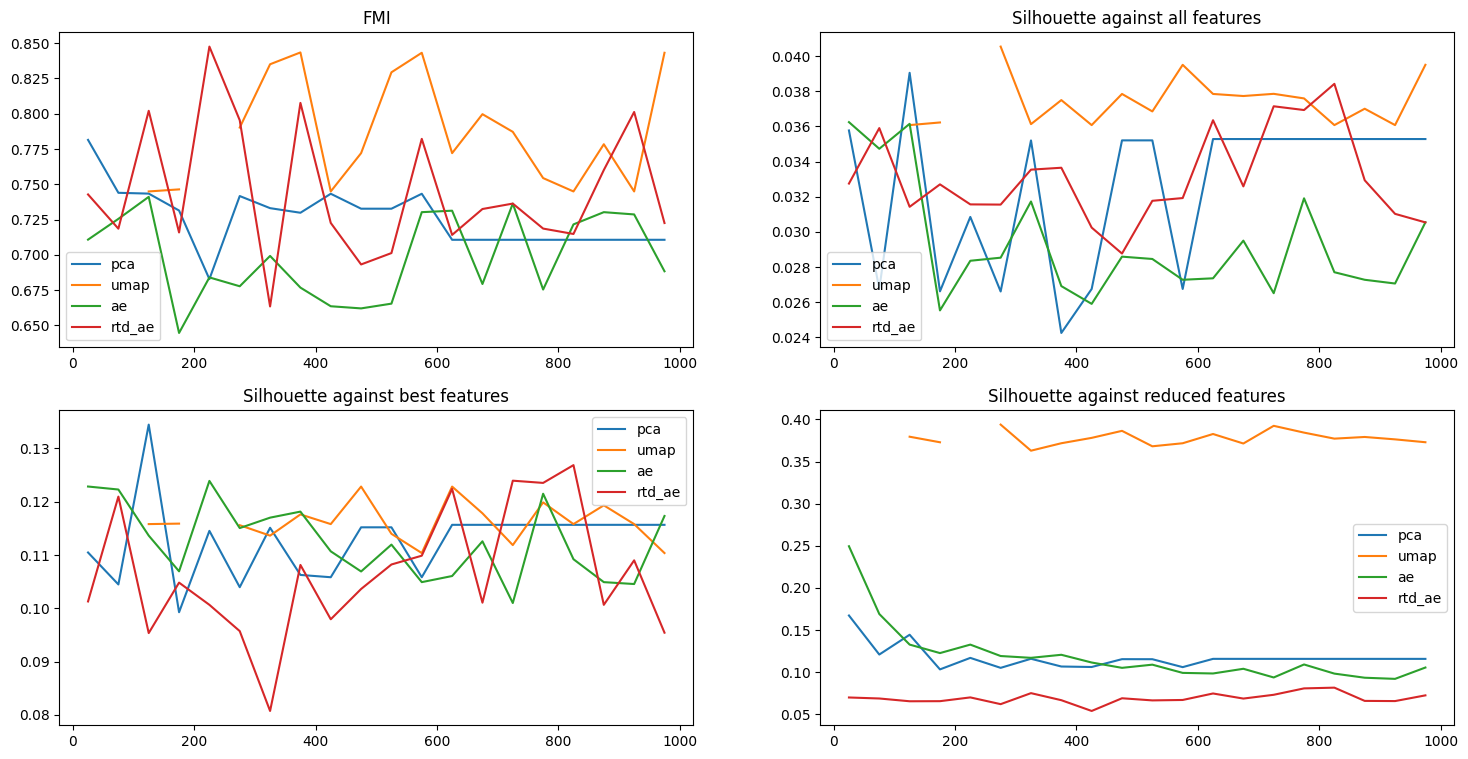

In [78]:
fig, axes = plt.subplots(2, 2, figsize = (18, 9))
ax_fmi, ax_silh_all, ax_silh_best, ax_silh_reduced = axes.flat

for (name, _, __) in methods:
    fmis = [ ]
    silh_all = [ ]
    silh_best = [ ]
    silh_reduced = [ ]

    for n_components in tqdm.tqdm(TRY_NUM_FEATURES, desc = name):
        reduced_features = numpy.load(f"{subj}/{exp}/features_reduced/{name}/{n_components}/features.npy")
        assert reduced_features.shape == (data.shape[0], n_components)

        results = pandas.read_csv(f"{subj}/{exp}/features_reduced/{name}/{n_components}/results.csv")
        try:
            result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
            edges = numpy.fromstring(result['St_edges'].strip('[]'), sep = ' ', dtype = numpy.uint)
        except:
            edges = None
    
        if edges is not None:
            fmis.append(SDA.clustquality.cluster_metrics_ground(edges_true, edges, [ "FMI" ])["FMI"])
            silh_all.append(SDA.clustquality.calc_stage_metr_noground(features, edges, [ "Silh" ]).mean()["Silh"])
            silh_best.append(SDA.clustquality.calc_stage_metr_noground(best_features, edges, [ "Silh" ]).mean()["Silh"])
            silh_reduced.append(SDA.clustquality.calc_stage_metr_noground(reduced_features, edges, [ "Silh" ]).mean()["Silh"])
        else:
            fmis.append(None)
            silh_all.append(None)
            silh_best.append(None)
            silh_reduced.append(None)

    ax_fmi.plot(TRY_NUM_FEATURES, fmis, label = name)
    ax_silh_all.plot(TRY_NUM_FEATURES, silh_all, label = name)
    ax_silh_best.plot(TRY_NUM_FEATURES, silh_best, label = name)
    ax_silh_reduced.plot(TRY_NUM_FEATURES, silh_reduced, label = name)

ax_fmi.set_title("FMI")
ax_silh_all.set_title("Silhouette against all features")
ax_silh_best.set_title("Silhouette against best features")
ax_silh_reduced.set_title("Silhouette against reduced features")

ax_fmi.legend()
ax_silh_all.legend()
ax_silh_best.legend()
ax_silh_reduced.legend()

fig.savefig(f"{subj}/{exp}/features_reduced/comparison.svg")

### Results

#### Estimator

In [57]:
def analyze(all_features: pandas.DataFrame, n_components: int, folder: str):
    folder = f"{subj}/{exp}/results/{folder}"
    os.makedirs(folder, exist_ok = True)

    # Scale features
    all_features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
    numpy.save(f"{folder}/all_features.npy", all_features)
    print(all_features.shape)

    # PCA
    pca = sklearn.decomposition.PCA(n_components = n_components, svd_solver = "full", random_state = 42)
    pca_features = pca.fit_transform(all_features)
    print(pca_features.shape)
    
    print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
    print([ round(x, 3) for x in pca.explained_variance_ratio_ ])
    numpy.save(f"{folder}/pca_features.npy", pca_features)

    # SDA
    sda = SDA.SDA(n_jobs = -1, scale = False, verbose = True)
    results, df_st_edges = sda.apply(pca_features)
    
    metrics = [ ]
    for row in tqdm.tqdm(results['St_edges']):
        metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
    results = pandas.concat([ results, pandas.DataFrame(metrics) ], axis = 1)
    
    results.to_csv(f"{folder}/results.csv")
    df_st_edges.to_csv(f"{folder}/df_st_edges.csv")

    # Analyze
    best_results = SDA.analytics.best_results(results, key = 'Avg-Silh')
    best_results.to_csv(f"{folder}/best_results.csv")
    
    best_result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_eeg_stages(raw_data, best_edges, epochs).savefig(f"{folder}/eeg_stages.svg")
    SDA.analytics.plot_stats(pca_features, epochs, best_result, df_st_edges).savefig(f"{folder}/stats.svg")

#### Традиционные признаки

(1046, 765)
(1046, 15)
Explained variance 0.71
[0.211, 0.156, 0.069, 0.063, 0.046, 0.032, 0.026, 0.02, 0.018, 0.015, 0.013, 0.012, 0.01, 0.009, 0.009]
Applying to 1046 samples with 15 features each


100%|██████████| 1344/1344 [00:04<00:00, 314.35it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,...,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,60,45,15,Median,40,"[0, 104, 282, 492, 560, 682, 784, 857, 976, 1046]",9,210,68,116.222222,...,20.577614,0.051424,84.802755,3.014466,0.19782,66.881786,1.740748,1.0,1.0,1.0


array([   0,  104,  282,  492,  560,  682,  784,  857,  976, 1046])

,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 101.1)","(101.9, 263.5)","(264.3, 455.5)","(456.3, 511.5)","(513.1, 620.3)","(621.1, 707.5)","(708.3, 771.5)","(772.3, 877.1)","(877.9, 938.7)"
"Time length, sec",91.2,161.6,191.2,55.2,107.2,86.4,63.2,104.8,60.8
Number of epochs,104,178,210,68,122,102,73,119,70


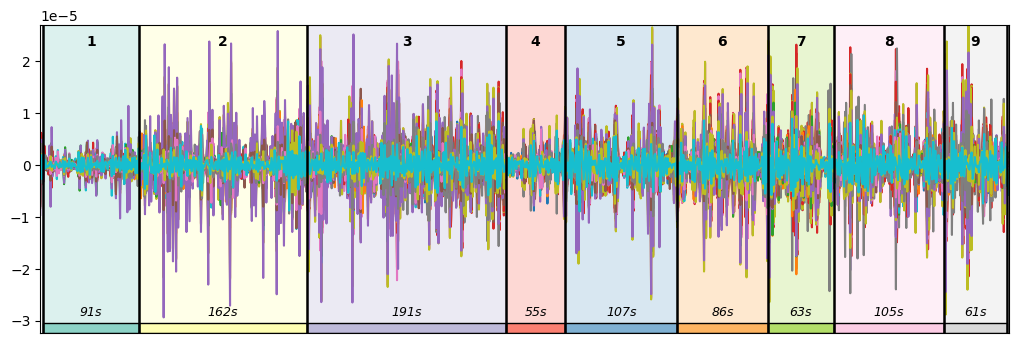

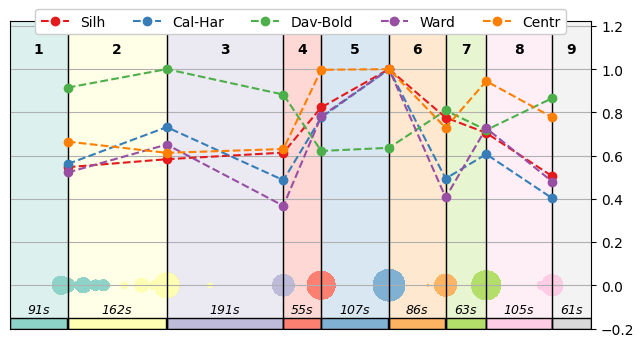

In [58]:
def read_traditional():
    df_ft_psd_loc_db = pandas.read_feather(f'{subj}/src/df_ft_psd_loc_db.feather')
    df_ft_psd_ind_loc_log = pandas.read_feather(f'{subj}/src/df_ft_psd_ind_loc_log.feather')
    df_ft_coh_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_coh_ind_loc.feather')
    df_ft_plv_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_plv_ind_loc.feather')

    result =  pandas.concat([
        df_ft_psd_loc_db,
        df_ft_psd_ind_loc_log,
        df_ft_coh_ind_loc,
        df_ft_plv_ind_loc
    ], axis = 1)

    if subj == "Subj2":
        result = result[:-2]
    return result

analyze(read_traditional(), 15, "traditional")

#### Топологические признаки + PCA

(1046, 19563)
(1046, 150)
Explained variance 0.7
[0.092, 0.034, 0.024, 0.017, 0.013, 0.013, 0.011, 0.01, 0.009, 0.008, 0.008, 0.008, 0.008, 0.007, 0.007, 0.007, 0.007, 0.007, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,

100%|██████████| 1344/1344 [00:04<00:00, 315.26it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,...,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,40,15,Mode,40,"[0, 92, 154, 252, 340, 552, 682, 842, 976, 1046]",9,212,62,116.222222,...,47.212316,-0.019478,15.175598,6.866266,0.053265,14.494349,4.790117,0.818841,0.664936,0.707666


array([   0,   92,  154,  252,  340,  552,  682,  842,  976, 1046])

,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 89.1)","(89.9, 145.9)","(146.7, 236.3)","(237.1, 316.3)","(317.1, 505.1)","(505.9, 620.3)","(621.1, 758.7)","(759.5, 877.1)","(877.9, 938.7)"
"Time length, sec",79.2,56.0,89.6,79.2,188.0,114.4,137.6,117.6,60.8
Number of epochs,92,62,98,88,212,130,160,134,70


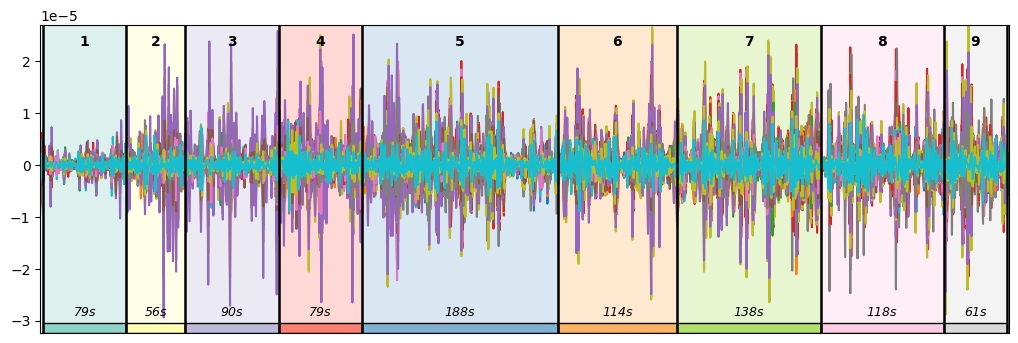

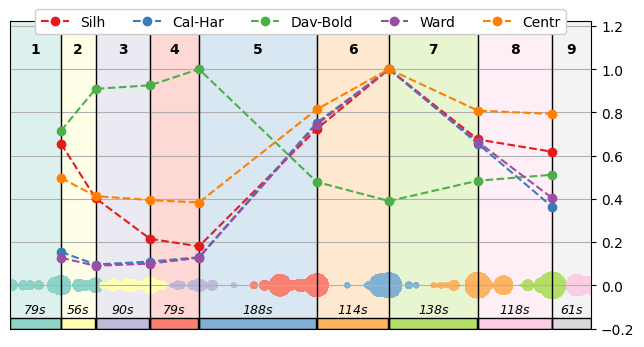

In [59]:
analyze(features, 150, "topological")

#### Топологические признаки + QSDA + PCA

(1046, 1888)
(1046, 25)
Explained variance 0.7
[0.201, 0.082, 0.06, 0.035, 0.03, 0.026, 0.023, 0.021, 0.02, 0.018, 0.017, 0.017, 0.016, 0.015, 0.014, 0.013, 0.013, 0.012, 0.012, 0.011, 0.011, 0.01, 0.009, 0.009, 0.008]
Applying to 1046 samples with 25 features each


100%|██████████| 1344/1344 [00:04<00:00, 318.13it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,...,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,60,40,10,Median,40,"[0, 124, 232, 304, 556, 682, 800, 856, 976, 1046]",9,252,56,116.222222,...,25.008775,-0.011112,50.597142,4.121364,0.167186,46.421696,2.386286,0.861583,0.748204,0.781451


array([   0,  124,  232,  304,  556,  682,  800,  856,  976, 1046])

,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 118.7)","(119.5, 217.1)","(217.9, 283.5)","(284.3, 508.3)","(509.1, 620.3)","(621.1, 722.7)","(723.5, 770.7)","(771.5, 877.1)","(877.9, 938.7)"
"Time length, sec",108.8,97.6,65.6,224.0,111.2,101.6,47.2,105.6,60.8
Number of epochs,124,108,72,252,126,118,56,120,70


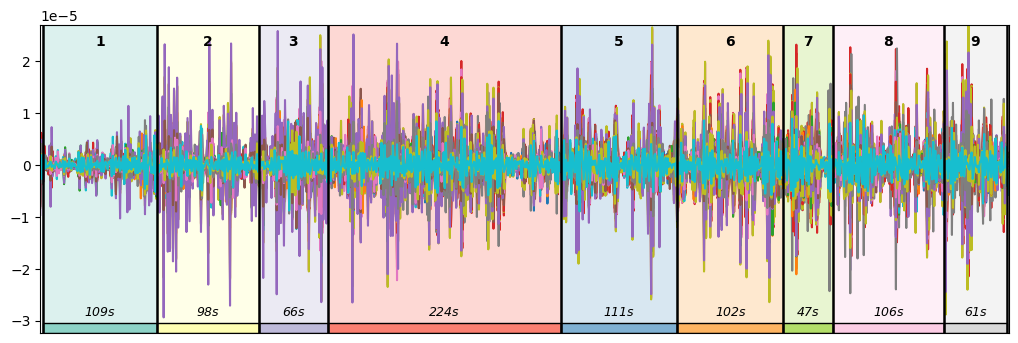

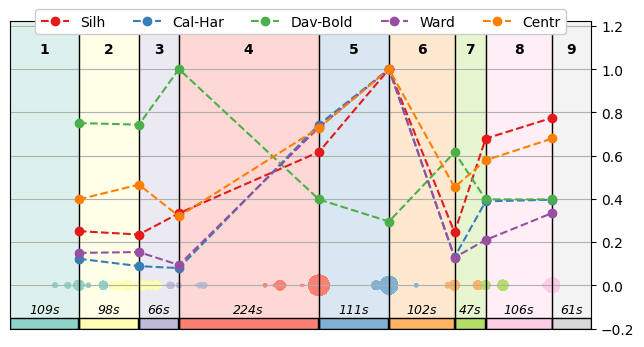

In [60]:
analyze(best_features, 25, "best_topological")

#### Традиционные и топологические вместе + PCA

(1046, 2653)
(1046, 30)
Explained variance 0.69
[0.175, 0.097, 0.06, 0.045, 0.034, 0.021, 0.019, 0.017, 0.016, 0.015, 0.014, 0.013, 0.013, 0.012, 0.012, 0.012, 0.011, 0.01, 0.01, 0.009, 0.009, 0.009, 0.008, 0.008, 0.008, 0.007, 0.007, 0.007, 0.006, 0.006]
Applying to 1046 samples with 30 features each


100%|██████████| 1344/1344 [00:05<00:00, 245.81it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,...,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,60,35,15,Mode,40,"[0, 141, 210, 486, 556, 682, 789, 856, 976, 1046]",9,276,67,116.222222,...,32.439332,0.006977,60.474159,3.301235,0.172334,48.837302,2.024231,0.870919,0.74893,0.783923


array([   0,  141,  210,  486,  556,  682,  789,  856,  976, 1046])

,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(9.9, 133.1)","(133.9, 198.7)","(199.5, 449.9)","(450.7, 508.3)","(509.1, 620.3)","(621.1, 711.5)","(713.1, 770.7)","(771.5, 877.1)","(877.9, 938.7)"
"Time length, sec",123.2,64.8,250.4,57.6,111.2,90.4,57.6,105.6,60.8
Number of epochs,141,69,276,70,126,107,67,120,70


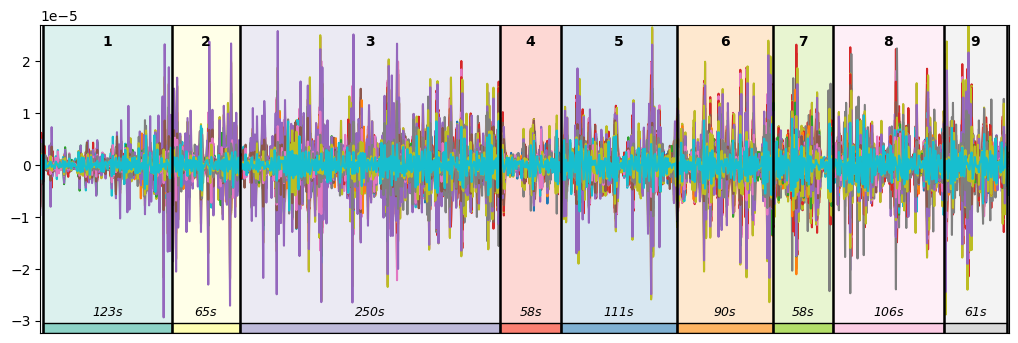

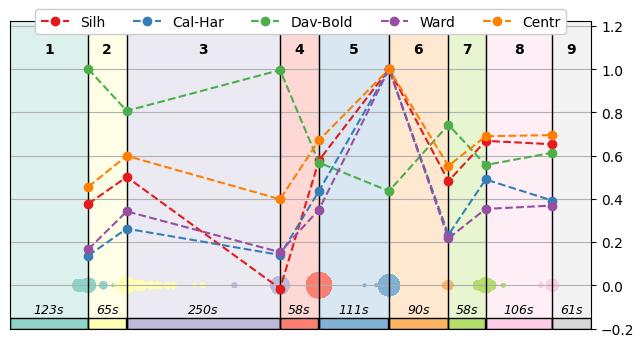

In [61]:
combined_features = pandas.concat([ read_traditional(), best_features ], axis = 1)
analyze(combined_features, 30, "combined")

### Information value

In [62]:
result_edges = numpy.loadtxt(f"{subj}/{exp}/results/best_topological/best_edges.txt").astype(numpy.int32)
print(result_edges)

if os.path.exists(f"{subj}/{exp}/IV/IV.csv"):
    ivs = pandas.read_csv(f"{subj}/{exp}/IV/IV.csv")
else:
    _, labels = SDA.stageprocess.form_stage_bands(result_edges)
    ivs = SDA.analytics.IV.calc_IV_clust(features, labels)

    os.makedirs(f"{subj}/{exp}/IV", exist_ok = True)
    ivs.to_csv(f"{subj}/{exp}/IV/IV.csv", index = False)

ivs["normalized_iv"] = sklearn.preprocessing.MinMaxScaler().fit_transform(ivs[["IV"]])
display(ivs)

[   0  124  232  304  556  682  800  856  976 1046]


,Feature,IV,IVs,normalized_iv
0,channel-0 betti dim-1 max,0.236125,"[0.3388194554640636, 0.05060157772318, 0.14265...",0.095039
1,channel-0 betti dim-1 mean,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000
2,channel-0 betti dim-1 std,0.356340,"[0.48177638238239096, 0.1449951638359926, 0.11...",0.143426
3,channel-0 betti dim-1 sum,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000
4,channel-0 betti dim-1 percentile-25,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000
...,...,...,...,...
19558,overall bd2 dim-3 percentile-75,0.552912,"[0.6417271266935757, 0.2402697703540903, 0.188...",0.222545
19559,overall bd2 dim-3 kurtosis,0.111927,"[0.053588924827404696, 0.04452208765971821, 0....",0.045050
19560,overall bd2 dim-3 skew,0.155667,"[0.08818294229076902, 0.03798987703853926, 0.0...",0.062656
19561,overall bd2 dim-3 norm-1,0.377466,"[0.3154193490200215, 0.0587256313112063, 0.172...",0.151929


In [63]:
iv_qsda_scores = scores.join(ivs, lsuffix = "name", rsuffix = "Feature")
iv_qsda_scores = iv_qsda_scores[["name", "unique_values", "score", "normalized_score", "IV", "normalized_iv"]]

iv_qsda_scores["score"] = iv_qsda_scores["score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)
iv_qsda_scores["normalized_score"] = iv_qsda_scores["normalized_score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'score', ascending = False)
iv_qsda_scores["QSDA_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'IV', ascending = False)
iv_qsda_scores["IV_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores["IDX_DIFF"] = iv_qsda_scores["QSDA_IDX"] - iv_qsda_scores["IV_IDX"]

iv_qsda_scores = iv_qsda_scores.sort_index()
display(iv_qsda_scores)

,name,unique_values,score,normalized_score,IV,normalized_iv,QSDA_IDX,IV_IDX,IDX_DIFF
0,channel-0 betti dim-1 max,31,0.000000,0.000000,0.236125,0.095039,14671,5563,9108
1,channel-0 betti dim-1 mean,1,0.000000,0.000000,0.000000,0.000000,15563,19527,-3964
2,channel-0 betti dim-1 std,376,0.605209,0.157498,0.356340,0.143426,8749,4170,4579
3,channel-0 betti dim-1 sum,1,0.000000,0.000000,0.000000,0.000000,16299,18357,-2058
4,channel-0 betti dim-1 percentile-25,1,0.000000,0.000000,0.000000,0.000000,16300,18356,-2056
...,...,...,...,...,...,...,...,...,...
19558,overall bd2 dim-3 percentile-75,861,1.207155,0.282587,0.552912,0.222545,4697,2198,2499
19559,overall bd2 dim-3 kurtosis,466,0.238506,0.081295,0.111927,0.045050,11626,10756,870
19560,overall bd2 dim-3 skew,538,0.422302,0.119489,0.155667,0.062656,10244,8289,1955
19561,overall bd2 dim-3 norm-1,861,2.375467,0.525370,0.377466,0.151929,540,4008,-3468


<Axes: >

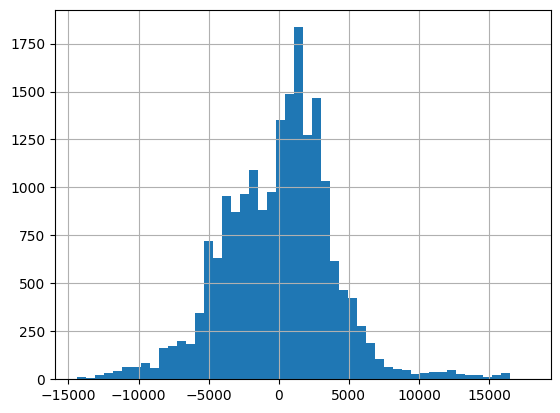

In [64]:
iv_qsda_scores["IDX_DIFF"].hist(bins = 50)

In [65]:
def vec_div(vec):
    mat1 = numpy.repeat(vec.reshape(-1, 1), repeats = len(vec), axis = 1)
    mat2 = numpy.repeat(vec.reshape(1, -1), repeats = len(vec), axis = 0)
    return numpy.sign(mat1 - mat2)

qsda = vec_div(iv_qsda_scores["score"].to_numpy())
iv = vec_div(iv_qsda_scores["IV"].to_numpy())

correct = ((qsda == iv).sum() - iv_qsda_scores.shape[0]) / 2
incorrect = ((qsda != iv).sum() - iv_qsda_scores.shape[0]) / 2

print(correct / 1e6, incorrect / 1e6)

143.336112 47.9998095


In [66]:
def sourceFilter(row):
    if row['Source'].startswith('dissim'):
        return 'dissim'
    return row['Source']

iv_qsda_scores[["Source", "Algorithm", "Dimension", "Stat"]] = iv_qsda_scores['name'].str.split(' ', expand = True)
iv_qsda_scores["Source"] = iv_qsda_scores.apply(sourceFilter, axis = 1)

In [67]:
def SourceRenamer(initial: str) -> str:
    if initial == 'dissim':
        return 'Correlations analysis'
    if initial == 'overall':
        return 'Overall processing'
    ind = initial.find('-') + 1
    comp = int(initial[ind:])
    return f'Comp. {comp} (ch. {epochs.ch_names[comp]})'

def AlgorithmRenamer(row):
    return {
        'amplitude-betti-1':        'Betti amp. with p=1',
        'amplitude-betti-2':        'Betti amp. with p=2',

        'amplitude-bottleneck':     'Bottleneck amp.',
        'amplitude-wasserstein-1':  'Wasserstein amp. with p=1',
        'amplitude-wasserstein-2':  'Wasserstein amp. with p=2',
        
        'amplitude-landscape-1-1':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-1-2':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-2-1':  'Pers. landscape amp. with p=2',
        'amplitude-landscape-2-2':  'Pers. landscape amp. with p=2',
        
        'amplitude-silhouette-1-1': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-1-2': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-2-1': 'Pers. silhouette amp. with p=2',
        'amplitude-silhouette-2-2': 'Pers. silhouette amp. with p=2',

        'bd2':                      'Stat. char. of (b + d) / 2',
        'life':                     'Stat. char. of lifetimes',
        'betti':                    'Stat. char. of Betti curves',
        'landscape':                'Stat. char. of pers. landscape',
        'silhouette-1':             'Stat. char. of lvl 1 pers. silh.',
        'silhouette-2':             'Stat. char. of lvl 2 pers. silh.',
        
        'entropy':                  'Persistence entropy',
        'numberofpoints':           'Number of points',
    }[row]

def DimensionRenamer(row):
    return {
        'all':        'All',
        'dim-1':      'Dimension 1',
        'dim-2':      'Dimension 2',
        'dim-3':      'Dimension 3',
        'dim-4':      'Dimension 4',
        'dim-5':      'Dimension 5',
        'norm-1':     'Amplitude norm with p=1',
        'norm-2':     'Amplitude norm with p=2',
    }[row]

def StatRenamer(row):
    return {
        'kurtosis':      'Kurtosis',
        'skew':          'Skew',
        'max':           'Maximum',
        'mean':          'Mean',
        'median':        'Median',
        'norm-1':        'Norm with p=1',
        'norm-2':        'Norm with p=2',
        'percentile-25': 'Percentile - 25',
        'percentile-75': 'Percentile - 75',
        'std':           'Standard deviation',
        'sum':           'Sum',
    }[row]

def draw(
    data: pandas.DataFrame,
    group_by: str,
    sort_by: str,
    ax,
    renamer: typing.Callable[[str], str],
    title: str
):
    stats = data.groupby(by = group_by).mean(numeric_only = True)
    stats = stats.sort_values(by = sort_by).reset_index()
    stats[group_by] = stats[group_by].apply(renamer)
    stats.plot.barh(x = group_by, y = sort_by, ax = ax)
    ax.set_title(title)
    ax.get_legend().remove()
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('')

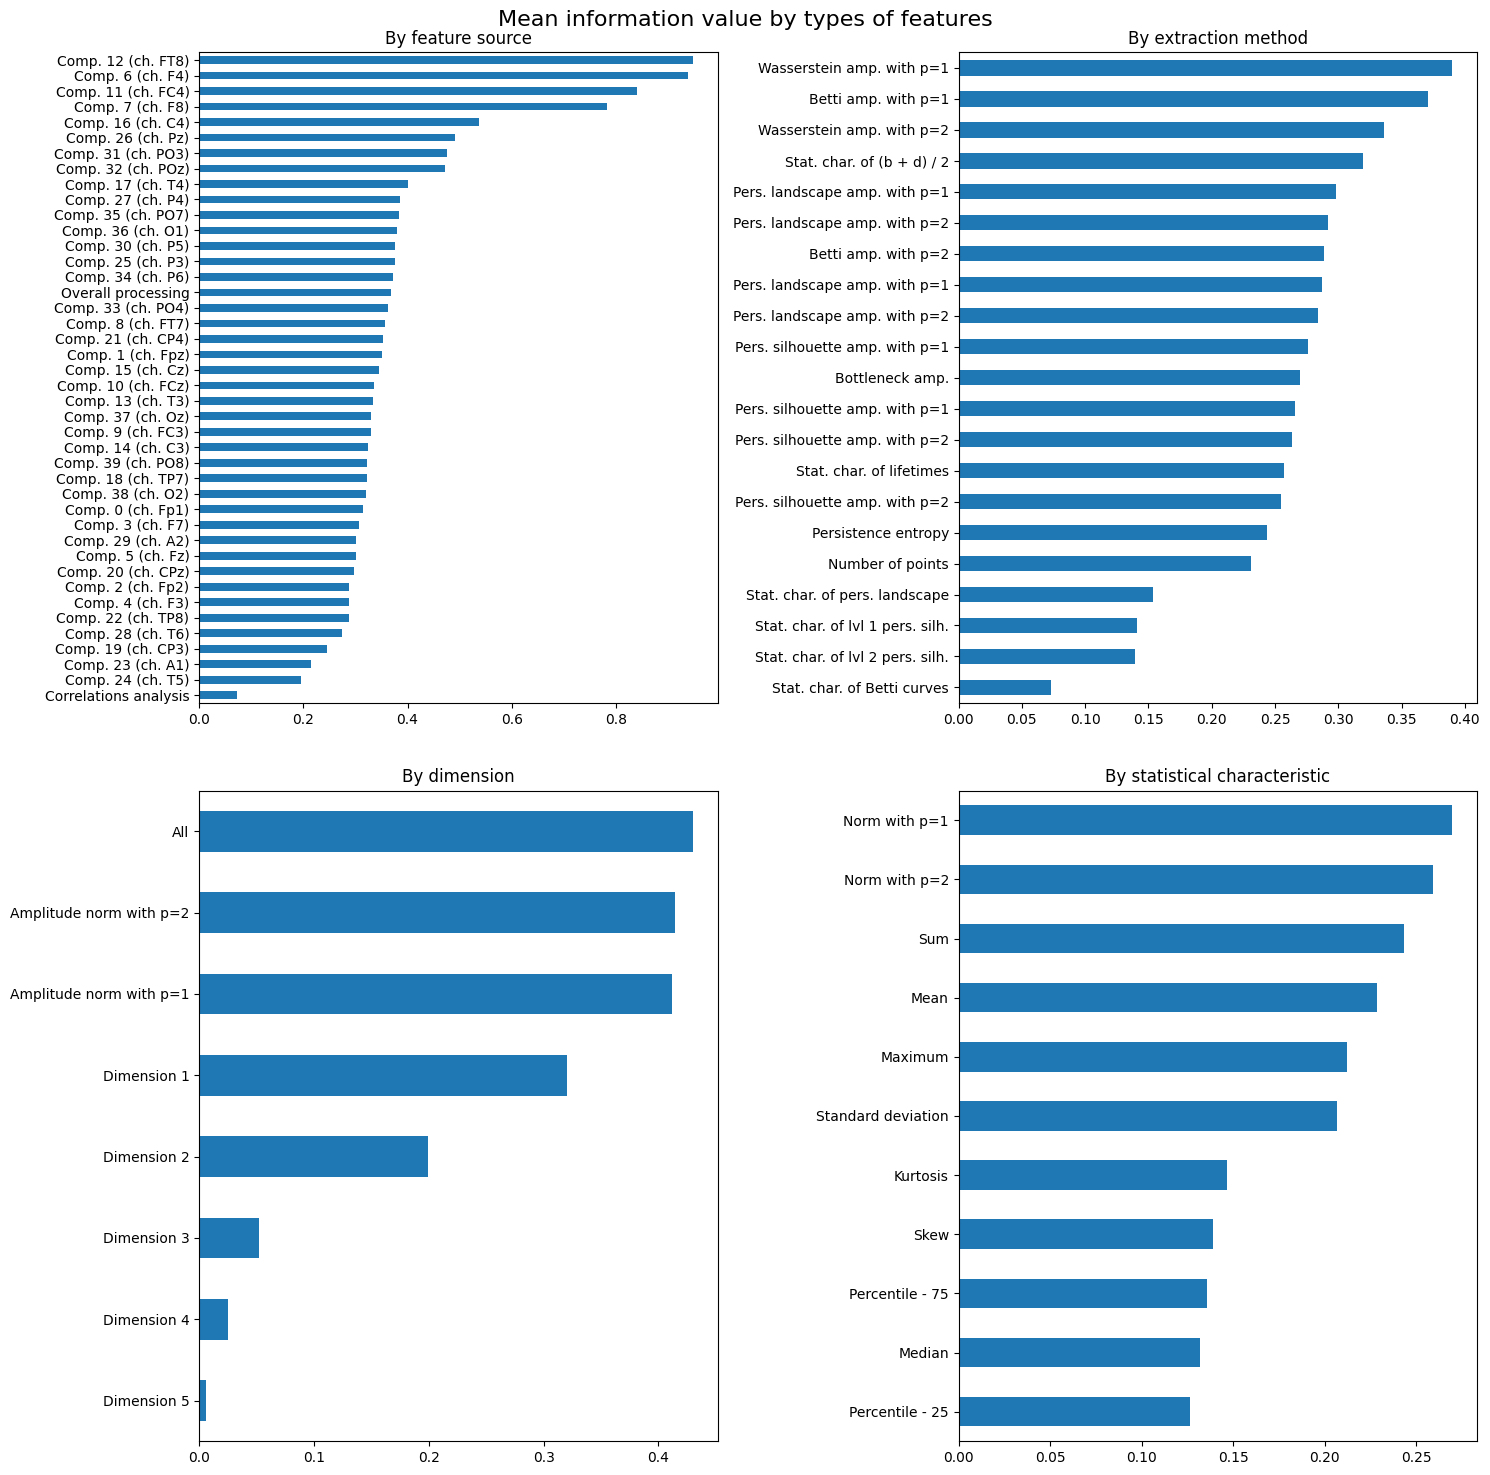

In [68]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
fig.suptitle('Mean information value by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'IV', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'IV', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'IV', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'IV', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.png")

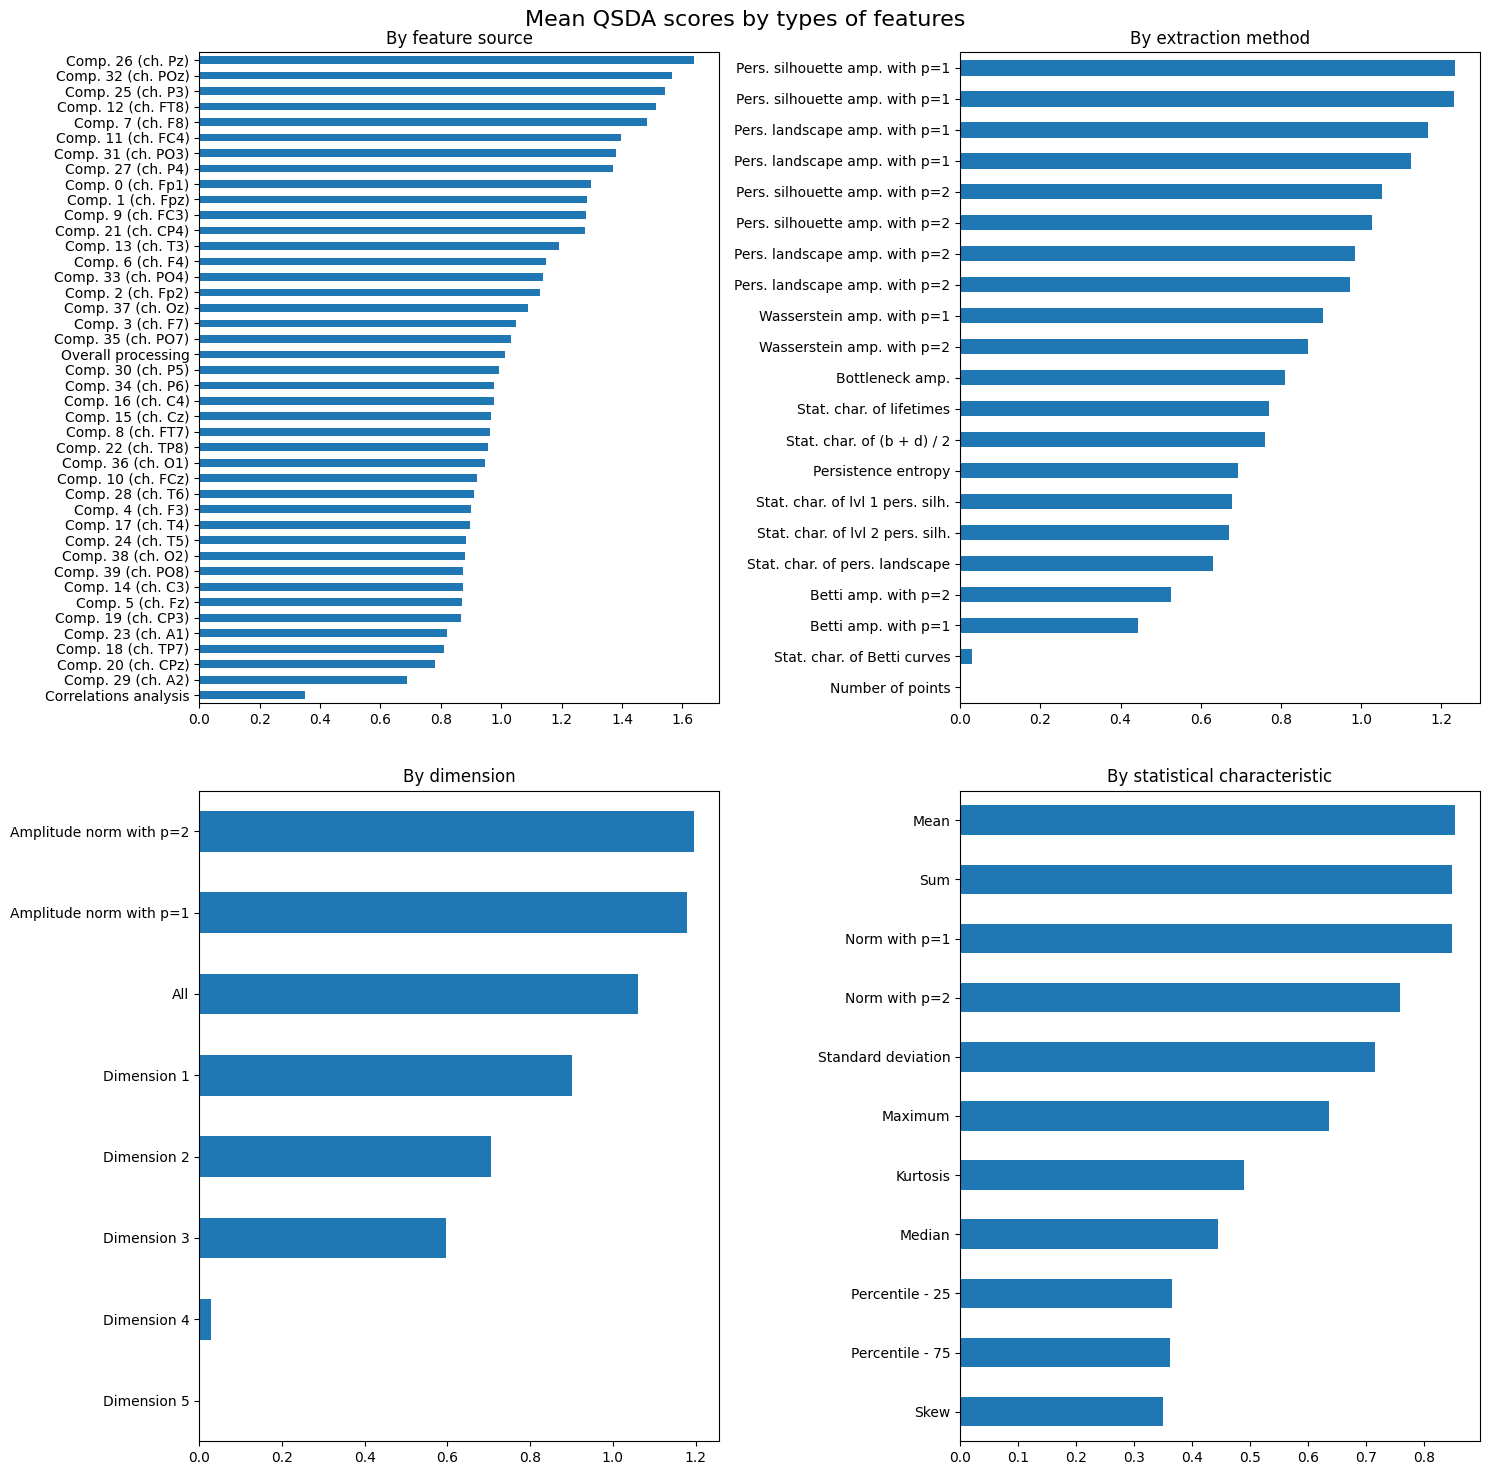

In [69]:
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
fig.suptitle('Mean QSDA scores by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'score', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'score', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'score', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'score', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.png")